In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

## Contents
1. **Data Overwiew.** <br> _First glance at the data._
2. **RoBERTa Model.** <br> _Fameous transformer architecture._
3. **Correlation of text comments with a numerical rating.** <br>_Visual outlook._<br>_Spearmans rho (corr coeff)._
4. **Data Arrangments.** <br>_Data containers creation and necessary computations._
5. **Products with best/worst reviews.** <br>_Products with most positive comments._<br>_Products with most negative comments_
6. **Sellers with best/worst reviews.** <br>_Sellers with most positive comments._<br>_Sellers with most negative comments_

In this notebook, SQLAlchemy is used to retrieve data from the database.<br>
<br>
**What is SQLAlchemy?**<br>
SQLAlchemy is a Python library that essentially allows you to work with databases from the comfort of your notebook. It supports multiple Database Management Systems (DBMS) like SQLite, PostgreSQL, MySQL, and Oracle.<br><br>
Some details may vary with different database flavors, but the general idea is similar to our most simplified case, namely SQLite. First, let's create an engine and establish connection with our database and see some really basic info like the list of tables within our database.

In [2]:
from sqlalchemy import create_engine, inspect

# Create a database engine
engine = create_engine('sqlite:////home/petewojtczak/transactional_data.sqlite')
# Context manager is used to establish a connection
with engine.connect() as conn:
    # SQLAlchemy's Inspector is used to retrieve table names
    inspector = inspect(engine)
    table_names = inspector.get_table_names()
# Print the table names
print(table_names)

['order_items', 'order_reviews', 'orders', 'products', 'sellers']


Let's follow up on these tables and print out some essential details.

In [3]:
# Context manager is used to establish a connection
with engine.connect() as conn:
    inspector = inspect(engine)    
    for table_name in inspector.get_table_names():
        # Retrieve column information
        columns_info = inspector.get_columns(table_name)
        columns = [col['name'] for col in columns_info]        
        # Check for primary key
        primary_key = next((col['name'] for col in columns_info if col['primary_key']), None)        
        # Check for foreign keys
        foreign_keys_info = inspector.get_foreign_keys(table_name)
        foreign_key_columns = [fk['constrained_columns'][0] for fk in foreign_keys_info]        
        # Count the number of records in the table
        num_records_query = f"SELECT COUNT(*) FROM '{table_name}'"
        num_records = conn.execute(num_records_query).scalar()        
        # Print results
        print(f"\033[1m'{table_name}'\033[0m")
        print(f"Primary Key: {primary_key}")
        if foreign_key_columns:
            print("Foreign Key Column(s):")
            for fk_column in foreign_key_columns:
                print(f"  - {fk_column}")
        else:
            print("Foreign Key: None")
        print(f"Columns: {columns}")
        print(f"Number of Records: {num_records}\n")

'order_items'
Primary Key: order_items_pk
Foreign Key Column(s):
  - order_id
  - product_id
  - seller_id
Columns: ['order_items_pk', 'order_id', 'product_id', 'seller_id', 'price']
Number of Records: 110197

'order_reviews'
Primary Key: review_id
Foreign Key Column(s):
  - order_id
Columns: ['review_id', 'order_id', 'review_score', 'review_comment_message']
Number of Records: 39462

'orders'
Primary Key: order_id
Foreign Key: None
Columns: ['order_id', 'timestamp', 'customer_contact']
Number of Records: 96478

'products'
Primary Key: product_id
Foreign Key: None
Columns: ['product_id', 'product_category_name', 'product_weight_g']
Number of Records: 32216

'sellers'
Primary Key: seller_id
Foreign Key: None
Columns: ['seller_id', 'seller_state']
Number of Records: 2970



# 1) Data Overwiew

In [4]:
def columns_info(df):
    # columns' basic metadata for a given df
    columns_info = {
        'column': df.columns,
        'dtype': [df[col].dtype for col in df.columns],
        'nunique': [df[col].nunique() for col in df.columns]}
    columns_df = pd.DataFrame(columns_info)
    columns_df.set_index('column', inplace=True)
    columns_df.sort_values(by='nunique', ascending=False, inplace=True)
    return columns_df

## Order reviews

**Dataframe columns description**:
* `review_id`; PK, unique review identifier.<br>
* `order_id`; FK, order unique identifier.<br>
* `review_score`; note ranging from 1 to 5 given by the customer on a satisfaction survey.<br>
* `review_comment_message`; comment message from the review left by the customer, in Portuguese.<br>

In [5]:
df = pd.read_sql_query('SELECT * FROM order_reviews', engine, coerce_float=False)
df.head(3)

,review_id,order_id,review_score,review_comment_message
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...


In [6]:
# basic dataframe info
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
print(f'Data types: {set(df.dtypes.values)}')
print(f'Missing values: {df.isnull().values.any()}')
print(f"Duplicates: {df.duplicated().sum()}")

Number of rows: 39462
Number of columns: 4
Data types: {dtype('int64'), dtype('O')}
Missing values: False
Duplicates: 0


In [7]:
columns_info(df)

,dtype,nunique
column,,
review_id,object,39462
order_id,object,39397
review_comment_message,object,35059
review_score,int64,5


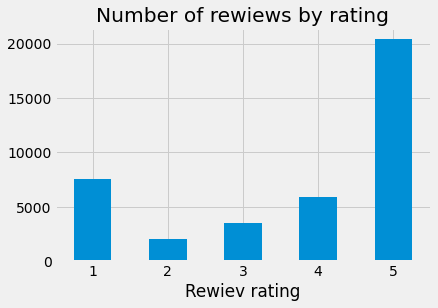

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# most common rating is 5
ax = df.review_score.value_counts().sort_index().plot(kind='bar', title='Number of rewiews by rating')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel('Rewiev rating')
plt.show()

# 2) RoBERTa Model 
Base model is BERTabaporu, a RoBERTa model trained on Portuguese tweets. Fameous transformer architecture.<br> 135M parameters, fine-tuned specifically for our task. <br>https://huggingface.co/pysentimiento/bertweet-pt-sentiment

In [9]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pysentimiento import create_analyzer

analyzer = create_analyzer(task="sentiment", lang="pt")

for index, row in df.iterrows():
    output = analyzer.predict(row.review_comment_message)
    df.loc[index, 'sentiment'] = output.output
    probabilities = output.probas
    df.loc[index, 'POS'] = probabilities['POS']
    df.loc[index, 'NEU'] = probabilities['NEU']
    df.loc[index, 'NEG'] = probabilities['NEG']

CPU times: user 2h 9min 32s, sys: 18.7 s, total: 2h 9min 50s
Wall time: 23min 2s


In [10]:
df.head(3)

,review_id,order_id,review_score,review_comment_message,sentiment,POS,NEU,NEG
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,NEU,0.083059,0.865634,0.051306
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,POS,0.989135,0.008621,0.002244
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,NEG,0.040093,0.322280,0.637627


# 3) Correlation of text comments with a numerical rating

## Visual outlook

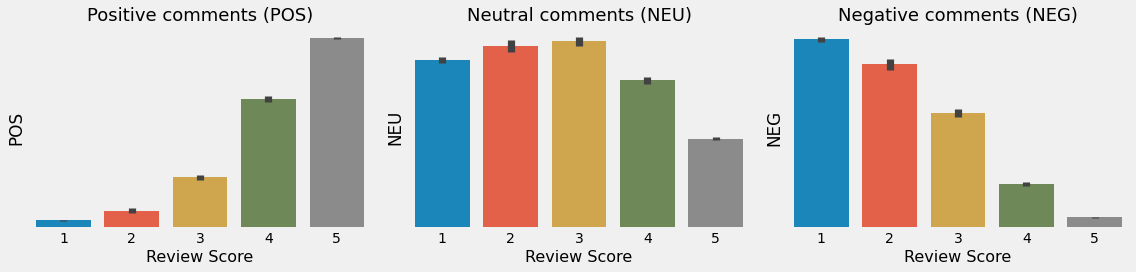

In [11]:
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
sns.barplot(data=df, x='review_score', y='POS', ax=axs[0])
sns.barplot(data=df, x='review_score', y='NEU', ax=axs[1])
sns.barplot(data=df, x='review_score', y='NEG', ax=axs[2])

axs[0].set_title('Positive comments (POS)', fontsize=18)
axs[1].set_title('Neutral comments (NEU)', fontsize=18)
axs[2].set_title('Negative comments (NEG)', fontsize=18)

for ax in axs:
    ax.set_xlabel('Review Score', fontsize=16)
    ax.set(yticks=[])
    ax.tick_params(axis='x', labelsize=14)

plt.tight_layout()
plt.show()

## Spearmans rho (corr coeff)
We can calculate formal corelation coeff appropriate for two ordinal variables.

In [12]:
from scipy.stats import spearmanr

# first, we need to move towards numbers 
sentiment_mapping = {'NEG': 0, 'NEU': 1, 'POS': 2}
for index, row in df.iterrows():
    df.loc[index, 'NUM_sentiment'] = sentiment_mapping.get(row.sentiment)
    
# this is the corr coeff appriopriate here
rho, p_value = spearmanr(df.NUM_sentiment, df.review_score)
print("Spearman's rho:", rho)
print("p-value:", p_value)

Spearman's rho: 0.6773645765197137
p-value: 0.0


Positive corr coeff, as expected (Spearman's rho ranges from -1 to 1). Note that Null Hypothesis here is 'no correlation' and probability under the Null (p-value) is equal:

In [13]:
print("{:.20f}".format(p_value))

0.00000000000000000000


# 4) Data Arrangments

## Sellers

**Dataframe columns description**:
* `seller_id`; PK, seller unique identifier.<br>
* `seller_state`; state of the seller.<br>

In [14]:
sellers = pd.read_sql_query('SELECT * FROM sellers', engine, coerce_float=False)
sellers.head(3)

,seller_id,seller_state
0,3442f8959a84dea7ee197c632cb2df15,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,RJ


In [15]:
# basic dataframe info
print(f'Number of rows: {sellers.shape[0]}')
print(f'Number of columns: {sellers.shape[1]}')
print(f'Data types: {set(sellers.dtypes.values)}')
print(f'Missing values: {sellers.isnull().values.any()}')
print(f"Duplicates: {sellers.duplicated().sum()}")

Number of rows: 2970
Number of columns: 2
Data types: {dtype('O')}
Missing values: False
Duplicates: 0


In [16]:
columns_info(sellers)

,dtype,nunique
column,,
seller_id,object,2970
seller_state,object,22


In [17]:
# container creation
sellers = sellers.set_index('seller_id')
sellers = sellers.assign(POS=0, NEU=0, NEG=0)
seller = sellers[['POS', 'NEU', 'NEG']]
seller.head(3)

,POS,NEU,NEG
seller_id,,,
3442f8959a84dea7ee197c632cb2df15,0,0,0
d1b65fc7debc3361ea86b5f14c68d2e2,0,0,0
ce3ad9de960102d0677a81f5d0bb7b2d,0,0,0


## Products

**Dataframe columns description**:
* `product_id`; PK, product unique identifier.<br>
* `product_category_name`; root category of product, in Portuguese.<br>
* `product_weight_g`; product weight measured in grams.

In [18]:
products = pd.read_sql_query('SELECT * FROM products', engine, coerce_float=False)
products.head(3)

,product_id,product_category_name,product_weight_g
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0


In [19]:
# basic dataframe info
print(f'Number of rows: {products.shape[0]}')
print(f'Number of columns: {products.shape[1]}')
print(f'Data types: {set(products.dtypes.values)}')
print(f'Missing values: {products.isnull().values.any()}')
print(f"Duplicates: {products.duplicated().sum()}")

Number of rows: 32216
Number of columns: 3
Data types: {dtype('float64'), dtype('O')}
Missing values: True
Duplicates: 0


In [20]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32216 entries, 0 to 32215
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32216 non-null  object 
 1   product_category_name  32216 non-null  object 
 2   product_weight_g       32214 non-null  float64
dtypes: float64(1), object(2)
memory usage: 755.2+ KB


In [21]:
columns_info(products)

,dtype,nunique
column,,
product_id,object,32216
product_weight_g,float64,2171
product_category_name,object,74


In [22]:
# container creation
products = products.set_index('product_id')
products = products.assign(POS=0, NEU=0, NEG=0)
product = products[['POS', 'NEU', 'NEG']]
product.head(3)

,POS,NEU,NEG
product_id,,,
1e9e8ef04dbcff4541ed26657ea517e5,0,0,0
3aa071139cb16b67ca9e5dea641aaa2f,0,0,0
96bd76ec8810374ed1b65e291975717f,0,0,0


## Order items
A dataframe serving as a container for a set of items associated with each order, along with each item info like `product_id`, `price` etc.

**Dataframe columns description**:
* `order_items_pk`; PK, row unique identifier.<br>
* `order_id`; FK, order unique identifier.<br>
* `product_id`; FK, product unique identifier.<br>
* `seller_id`; FK, seller unique identifier.<br>
* `price`; item price.

In [23]:
order_items = pd.read_sql_query('SELECT * FROM order_items', engine, coerce_float=False)
order_items.head(3)

,order_items_pk,order_id,product_id,seller_id,price
0,0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9
1,1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9
2,2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0


In [24]:
# basic dataframe info
print(f'Number of rows: {order_items.shape[0]}')
print(f'Number of columns: {order_items.shape[1]}')
print(f'Data types: {set(order_items.dtypes.values)}')
print(f'Missing values: {order_items.isnull().values.any()}')
print(f"Duplicates: {order_items.duplicated().sum()}")

Number of rows: 110197
Number of columns: 5
Data types: {dtype('int64'), dtype('float64'), dtype('O')}
Missing values: False
Duplicates: 0


In [25]:
columns_info(order_items)

,dtype,nunique
column,,
order_items_pk,int64,110197
order_id,object,96478
product_id,object,32216
price,float64,5859
seller_id,object,2970


In [26]:
order_items = order_items.drop(['order_items_pk'], axis=1)
order_items.head(3)

,order_id,product_id,seller_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0


We will exclude dupicates assiciated with buying same products in one order.

In [27]:
order_items = order_items.drop_duplicates(subset=['order_id', 'product_id'], keep='first')

## Data calculation
Now we need to cycle through our rewiews and fill created containers accordingly, as given below (essentialy we are just counting stuff along the way).

In [28]:
%%time
df.set_index('order_id', inplace=True)
order_items.set_index('order_id', inplace=True)
for index, row in df.iterrows():
    if index not in order_items.index:
        continue
    if isinstance(order_items.loc[index], pd.Series):
        if row.sentiment == 'POS':
            product.loc[order_items.loc[index].product_id, 'POS'] += 1
            seller.loc[order_items.loc[index].seller_id, 'POS'] += 1
        elif row.sentiment == 'NEU':
            product.loc[order_items.loc[index].product_id, 'NEU'] += 1
            seller.loc[order_items.loc[index].seller_id, 'NEU'] += 1
        else:
            product.loc[order_items.loc[index].product_id, 'NEG'] += 1
            seller.loc[order_items.loc[index].seller_id, 'NEG'] += 1
    else:
        if row.sentiment == 'POS':
            for item in order_items.loc[index].iterrows():
                product.loc[item[1].product_id, 'POS'] += 1
                seller.loc[item[1].seller_id, 'POS'] += 1
        elif row.sentiment == 'NEU':
            for item in order_items.loc[index].iterrows():
                product.loc[item[1].product_id, 'NEU'] += 1
                seller.loc[item[1].seller_id, 'NEU'] += 1
        else:
            for item in order_items.loc[index].iterrows():
                product.loc[item[1].product_id, 'NEG'] += 1
                seller.loc[item[1].seller_id, 'NEG'] += 1

CPU times: user 31.1 s, sys: 192 ms, total: 31.3 s
Wall time: 30.9 s


In [29]:
product['total_rewievs'] = product['POS'] + product['NEU'] + product['NEG']
product['POS_ratio'] = product['POS'] / product['total_rewievs']
product['NEG_ratio'] = product['NEG'] / product['total_rewievs']

seller['total_rewievs'] = seller['POS'] + seller['NEU'] + seller['NEG']
seller['POS_ratio'] = seller['POS'] / seller['total_rewievs']
seller['NEG_ratio'] = seller['NEG'] / seller['total_rewievs']

# 5) Products with best/worst reviews

## Products with most positive comments

In [30]:
# most positive comments (nominal)
product.sort_values(by='POS', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
product_id,,,,,,
99a4788cb24856965c36a24e339b6058,105,63,54,222,0.472973,0.243243
422879e10f46682990de24d770e7f83d,93,42,23,158,0.588608,0.145570
389d119b48cf3043d311335e499d9c6b,89,40,20,149,0.597315,0.134228
368c6c730842d78016ad823897a372db,81,51,19,151,0.536424,0.125828
aca2eb7d00ea1a7b8ebd4e68314663af,73,58,19,150,0.486667,0.126667
2b4609f8948be18874494203496bc318,73,31,14,118,0.618644,0.118644
53759a2ecddad2bb87a079a1f1519f73,71,47,26,144,0.493056,0.180556
d1c427060a0f73f6b889a5c7c61f2ac4,62,58,13,133,0.466165,0.097744
53b36df67ebb7c41585e8d54d6772e08,60,34,11,105,0.571429,0.104762


In [31]:
# best share of positive comments
product[product['total_rewievs'] > 30].sort_values(by='POS_ratio', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
product_id,,,,,,
777d2e438a1b645f3aec9bd57e92672c,30,9,4,43,0.697674,0.093023
f1c7f353075ce59d8a6f3cf58f419c9c,57,21,4,82,0.695122,0.048780
617186c3d97ea56c9c683a8a3974e8c1,25,6,5,36,0.694444,0.138889
595fac2a385ac33a80bd5114aec74eb8,27,7,5,39,0.692308,0.128205
ec2d43cc59763ec91694573b31f1c29a,49,18,4,71,0.690141,0.056338
29427de7f8a9ee983d9dbc51cec569b4,28,5,8,41,0.682927,0.195122
2028bf1b01cafb2d2b1901fca4083222,34,11,5,50,0.680000,0.100000
629e019a6f298a83aeecc7877964f935,21,9,1,31,0.677419,0.032258
431d674f9a4fbd0957ecf6ba3fcb6899,21,7,3,31,0.677419,0.096774


Only products with al least 31 comments are listed. Please tweak code for desired minimal number of total rewievs.

## Products with most negative comments

In [32]:
# Products with most negative comments (nominal)
product.sort_values(by='NEG', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
product_id,,,,,,
99a4788cb24856965c36a24e339b6058,105,63,54,222,0.472973,0.243243
e0d64dcfaa3b6db5c54ca298ae101d05,24,24,30,78,0.307692,0.384615
89b121bee266dcd25688a1ba72eefb61,3,6,30,39,0.076923,0.769231
53759a2ecddad2bb87a079a1f1519f73,71,47,26,144,0.493056,0.180556
b1d207586fca400a2370d50a9ba1da98,1,8,25,34,0.029412,0.735294
84f456958365164420cfc80fbe4c7fab,23,15,25,63,0.365079,0.396825
422879e10f46682990de24d770e7f83d,93,42,23,158,0.588608,0.145570
7c1bd920dbdf22470b68bde975dd3ccf,50,25,22,97,0.515464,0.226804
b5e13c9a353102f79c6206ff5cb61a50,5,14,22,41,0.121951,0.536585


In [33]:
# Products with worst share of negative comments
product[product['total_rewievs'] > 30].sort_values(by='NEG_ratio', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
product_id,,,,,,
89b121bee266dcd25688a1ba72eefb61,3,6,30,39,0.076923,0.769231
b1d207586fca400a2370d50a9ba1da98,1,8,25,34,0.029412,0.735294
b5e13c9a353102f79c6206ff5cb61a50,5,14,22,41,0.121951,0.536585
84f456958365164420cfc80fbe4c7fab,23,15,25,63,0.365079,0.396825
e0d64dcfaa3b6db5c54ca298ae101d05,24,24,30,78,0.307692,0.384615
165f86fe8b799a708a20ee4ba125c289,23,11,16,50,0.460000,0.320000
dab2413ead0edda9967edbc9bda2a64e,10,18,12,40,0.250000,0.300000
a92930c327948861c015c919a0bcb4a8,23,20,18,61,0.377049,0.295082
4413a608a42bd21bbf9d5abbd58c249a,18,6,10,34,0.529412,0.294118


Only products with at least 31 comments are listed. Please tweak code for desired minimal number of total rewievs.

# 6) Sellers with best/worst reviews

## Sellers with most positive comments

In [34]:
# Sellers with most positive comments (nominal)
seller.sort_values(by='POS', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
seller_id,,,,,,
4a3ca9315b744ce9f8e9374361493884,438,282,233,953,0.459601,0.244491
6560211a19b47992c3666cc44a7e94c0,436,292,200,928,0.469828,0.215517
1f50f920176fa81dab994f9023523100,393,221,102,716,0.548883,0.142458
cc419e0650a3c5ba77189a1882b7556a,384,204,105,693,0.554113,0.151515
7a67c85e85bb2ce8582c35f2203ad736,315,107,70,492,0.640244,0.142276
da8622b14eb17ae2831f4ac5b9dab84a,297,177,95,569,0.521968,0.166960
4869f7a5dfa277a7dca6462dcf3b52b2,226,147,82,455,0.496703,0.180220
955fee9216a65b617aa5c0531780ce60,222,179,77,478,0.464435,0.161088
3d871de0142ce09b7081e2b9d1733cb1,212,125,95,432,0.490741,0.219907


In [35]:
# Sellers with best share of positive comments
seller[seller['total_rewievs'] > 30].sort_values(by='POS_ratio', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
seller_id,,,,,,
744dac408745240a2c2528fb1b6028f3,33,4,1,38,0.868421,0.026316
d921b68bf747894be13a97ae52b0f386,26,3,2,31,0.838710,0.064516
12b9676b00f60f3b700e83af21824c0e,54,7,5,66,0.818182,0.075758
a5cba26a62b8b4d0145b68b841e62e7f,24,7,0,31,0.774194,0.000000
ac3508719a1d8f5b7614b798f70af136,35,11,2,48,0.729167,0.041667
7681ef142fd2c19048da7430856b5588,24,8,2,34,0.705882,0.058824
0509040ea3fe50071181bbc359eb7738,24,7,3,34,0.705882,0.088235
6cd68b3ed6d59aaa9fece558ad360c0a,42,14,4,60,0.700000,0.066667
54a1852d1b8f10312c55e906355666ee,57,12,13,82,0.695122,0.158537


Only sellers with al least 31 comments are listed. Please tweak code for desired minimal numer of total rewievs.

## Sellers with most negative comments

In [36]:
# Sellers with most negative comments (nominal)
seller.sort_values(by='NEG', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
seller_id,,,,,,
4a3ca9315b744ce9f8e9374361493884,438,282,233,953,0.459601,0.244491
6560211a19b47992c3666cc44a7e94c0,436,292,200,928,0.469828,0.215517
7c67e1448b00f6e969d365cea6b010ab,139,217,157,513,0.270955,0.306043
ea8482cd71df3c1969d7b9473ff13abc,199,199,109,507,0.392505,0.214990
cc419e0650a3c5ba77189a1882b7556a,384,204,105,693,0.554113,0.151515
1f50f920176fa81dab994f9023523100,393,221,102,716,0.548883,0.142458
da8622b14eb17ae2831f4ac5b9dab84a,297,177,95,569,0.521968,0.166960
3d871de0142ce09b7081e2b9d1733cb1,212,125,95,432,0.490741,0.219907
1025f0e2d44d7041d6cf58b6550e0bfa,169,153,85,407,0.415233,0.208845


In [37]:
# Sellers with worst share of negative comments
seller[seller['total_rewievs'] > 30].sort_values(by='NEG_ratio', ascending=False).head(10)

,POS,NEU,NEG,total_rewievs,POS_ratio,NEG_ratio
seller_id,,,,,,
1ca7077d890b907f89be8c954a02686a,2,22,57,81,0.024691,0.703704
2eb70248d66e0e3ef83659f71b244378,14,32,71,117,0.119658,0.606838
54965bbe3e4f07ae045b90b0b8541f52,7,16,24,47,0.148936,0.510638
a49928bcdf77c55c6d6e05e09a9b4ca5,11,15,25,51,0.215686,0.490196
710e3548e02bc1d2831dfc4f1b5b14d4,16,19,30,65,0.246154,0.461538
972d0f9cf61b499a4812cf0bfa3ad3c4,14,14,21,49,0.285714,0.428571
8444e55c1f13cd5c179851e5ca5ebd00,10,14,18,42,0.238095,0.428571
a7f13822ceb966b076af67121f87b063,6,17,17,40,0.150000,0.425000
6fd52c528dcb38be2eea044946b811f8,6,14,14,34,0.176471,0.411765


Only sellers with at least 31 comments are listed. Please tweak code for desired minimal number of total rewievs.